In [40]:
from matplotlib import pyplot as plt

In [41]:
from pyveg.src.data_analysis_utils import *
%matplotlib inline


In [42]:

def resample_time_series(df, col_name="offset50",period = "D"):
    """
    Resample and interpolate a time series dataframe so we have one row
    per day (useful for FFT)

    Parameters
    ----------
    df: DataFrame with date as index
    col_name: string, identifying the column we will pull out

    Returns
    -------
    new_series: pandas Series with datetime index, and one column, one row per day
    """
    series = df[col_name]
    # just in case the index isn't already datetime type
    series.index = pd.to_datetime(series.index)

    # resample to get one row per day
    rseries = series.resample(period).mean()
    
    new_series = rseries.interpolate()

    return new_series

In [43]:
def read_file_create_ts(input_dir):

    output_dir = os.path.join(input_dir, 'analysis')

    # check file exists
    json_summary_path = os.path.join(input_dir, 'results_summary.json')
    dfs = variable_read_json_to_dataframe(json_summary_path)
    
    
    dfs = drop_veg_outliers(dfs, sigmas=3) # not convinced this is really helping much

    # drop outliers and smooth results
    time_series_dfs = make_time_series(smooth_veg_data(dfs.copy(), n=5)) # increase smoothing with n>5

    #time_series_dfs = make_time_series(dfs)
    
    offsets = resample_time_series(time_series_dfs['COPERNICUS/S2'], col_name="offset50_smooth_mean",period="M")
    precipitation = resample_time_series(time_series_dfs['ECMWF/ERA5/MONTHLY'], col_name="total_precipitation",period="M")

    precipitation = precipitation[precipitation.index.isin(offsets.index)]
    return offsets, precipitation


In [44]:
input_dir_spots = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/Copernicus_Spots_2016_2020/__2020-03-09_16-46-33/'
input_dir_laberynths = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/labyrinths/'
input_dir_gaps = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/gaps/'


In [45]:
offsets_spots, precipitation_spots = read_file_create_ts(input_dir_spots)
offsets_gaps, precipitation_gaps = read_file_create_ts(input_dir_gaps)
offsets_labs, precipitation_labs = read_file_create_ts(input_dir_laberynths)



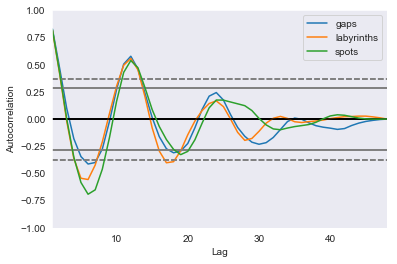

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(offsets_gaps,label='gaps')
autocorrelation_plot(offsets_labs,label='labyrinths')
autocorrelation_plot(offsets_spots,label='spots')
plt.show()

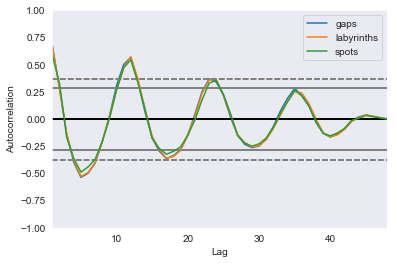

In [47]:

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(precipitation_gaps,label='gaps')
autocorrelation_plot(precipitation_labs,label='labyrinths')
autocorrelation_plot(precipitation_spots,label='spots')

plt.show()


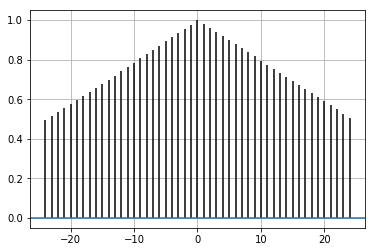

In [9]:

fig, ax1 = plt.subplots(1, 1, sharex=True)

ax1.xcorr(offsets_spots, offsets_gaps, usevlines=True, maxlags=24, normed=True, lw=1.5)
ax1.grid(True)


plt.show()

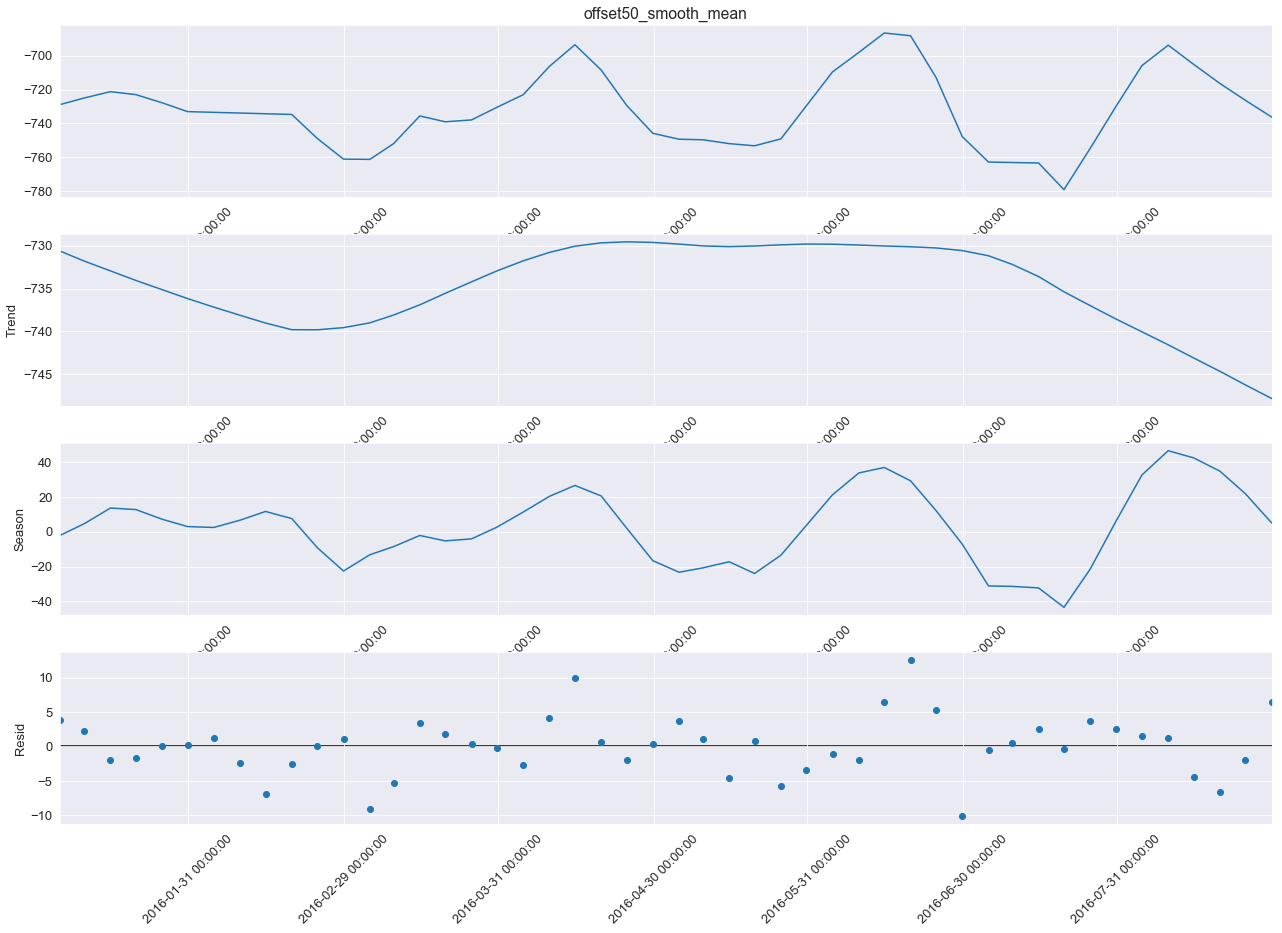

In [10]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(offsets_spots, period=12)
res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(offsets_spots.index, rotation = 45, va="center", position=(0,-0.28))

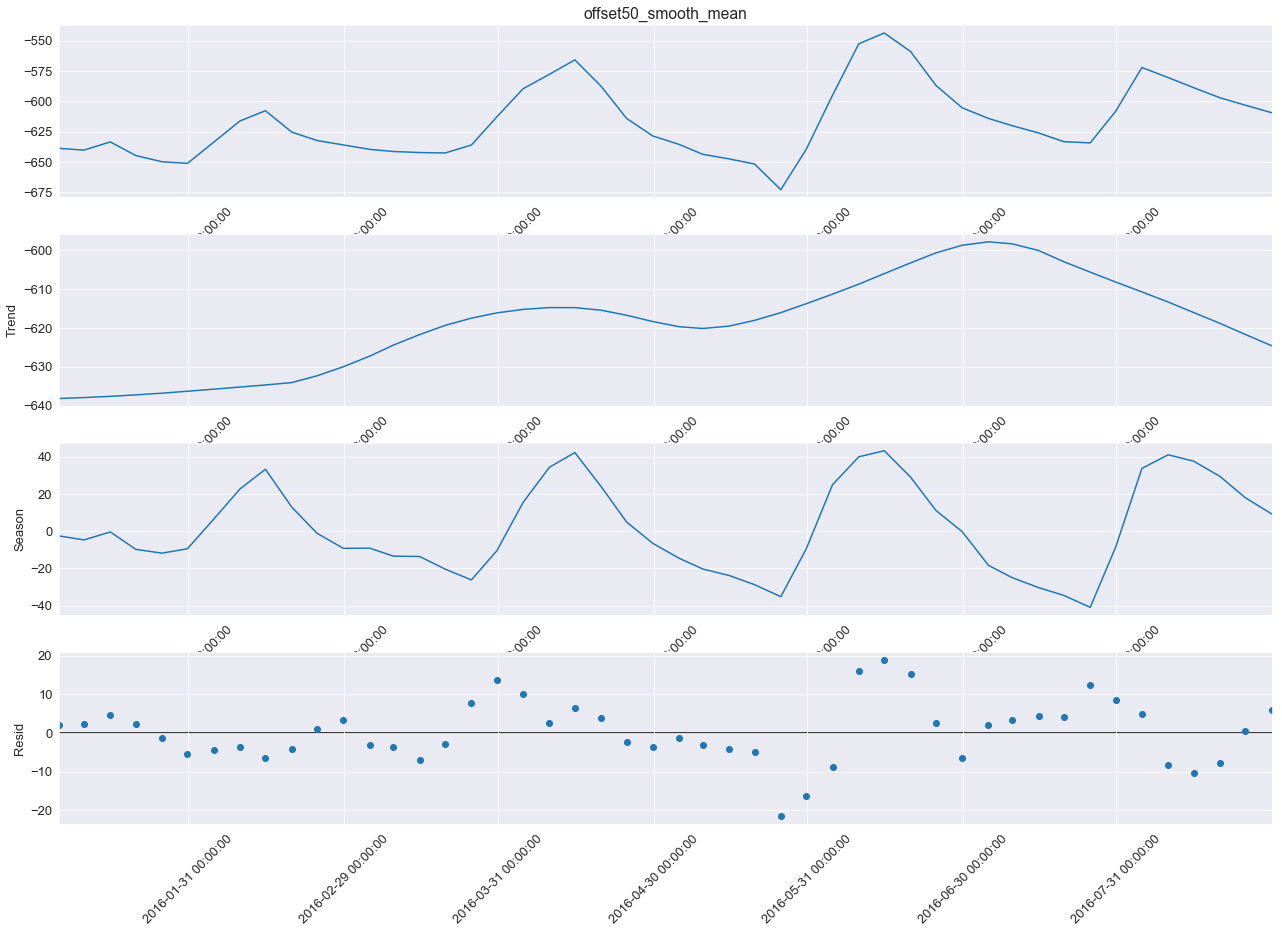

In [11]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(offsets_gaps, period=12)

res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(offsets_gaps.index, rotation = 45, va="center", position=(0,-0.28))

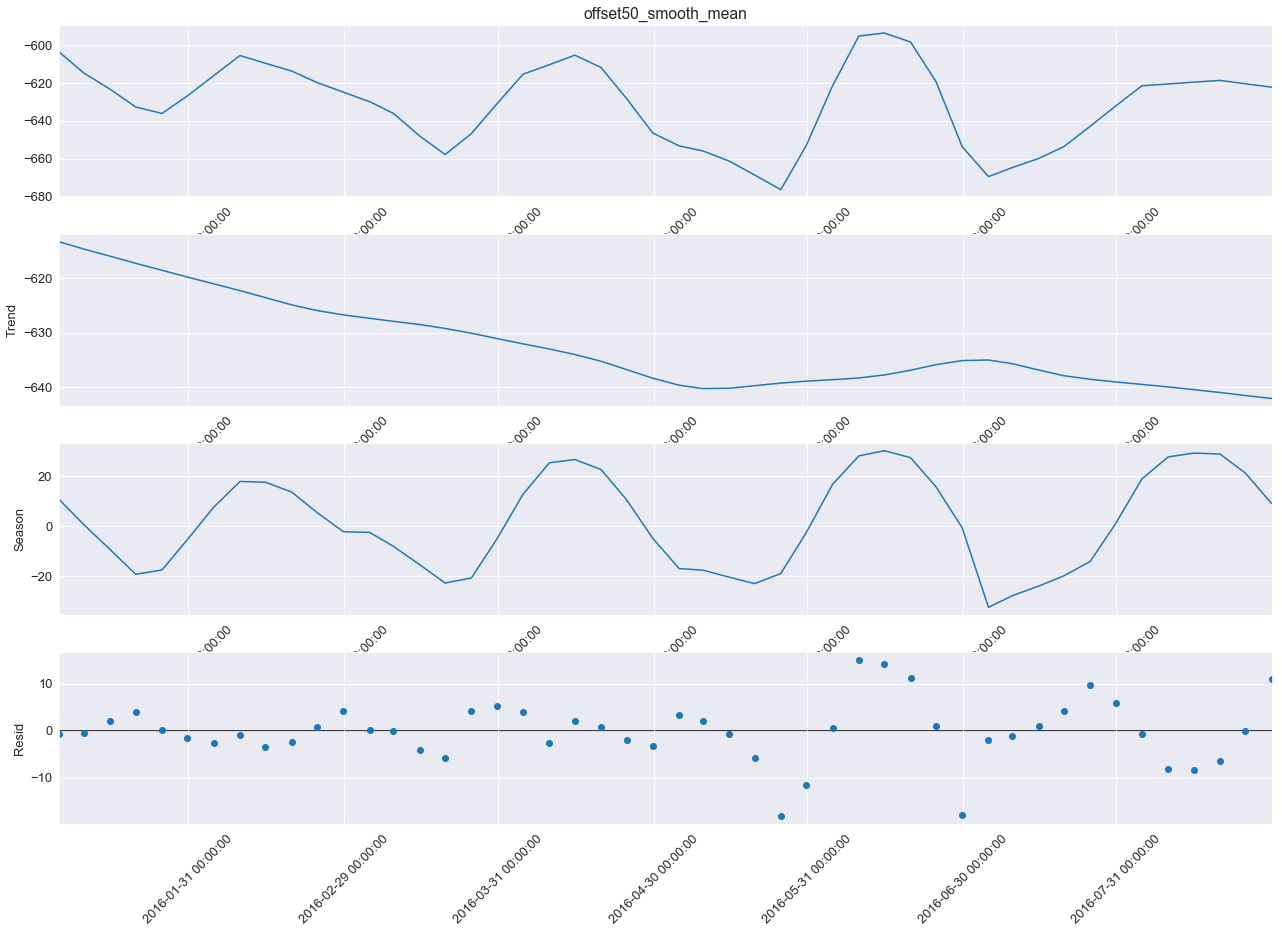

In [12]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(offsets_labs, period=12)

res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(offsets_labs.index, rotation = 45, va="center", position=(0,-0.28))

In [36]:
df_temp = pd.DataFrame(precipitation_labs)

df1 = pd.DataFrame(offsets_labs)
df2 = pd.DataFrame(offsets_gaps)
df3 = pd.DataFrame(offsets_spots)


df1.rename(columns={"offset50_smooth_mean": "labs"},inplace=True)
df2.rename(columns={"offset50_smooth_mean": "gaps"},inplace=True)
df3.rename(columns={"offset50_smooth_mean": "spots"},inplace=True)



endog = df1.join(df2, how='outer')
endog = endog.join(df3, how='outer')


endog['spots'] = (endog['spots'] - endog['spots'].mean()) / endog['spots'].std()
endog['gaps'] = (endog['gaps'] - endog['gaps'].mean()) / endog['gaps'].std()
endog['labs'] = (endog['labs'] - endog['labs'].mean()) / endog['labs'].std()


In [37]:
endog = endog.join(df_temp, how='outer')
endog.dropna(inplace = True)

endog['total_precipitation'] = (endog['total_precipitation'] - endog['total_precipitation'].mean()) / endog['total_precipitation'].std()


In [38]:
import statsmodels.api as sm

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

In [39]:
print(res.summary(separate_params=False))


                                          Statespace Model Results                                          
Dep. Variable:     ['labs', 'gaps', 'spots', 'total_precipitation']   No. Observations:                   48
Model:                            DynamicFactor(factors=1, order=2)   Log Likelihood                 -90.306
                                                     + AR(2) errors   AIC                            216.612
Date:                                              Thu, 02 Apr 2020   BIC                            250.294
Time:                                                      17:34:44   HQIC                           229.340
Sample:                                                  01-31-2016                                         
                                                       - 12-31-2019                                         
Covariance Type:                                                opg                                         
                   

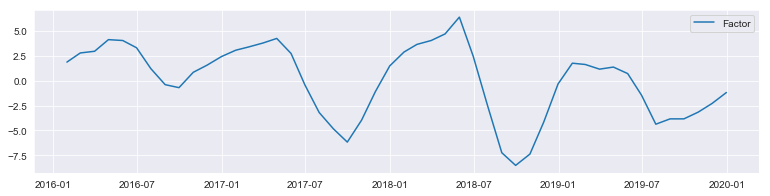

In [49]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

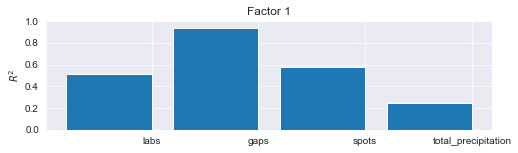

In [50]:
res.plot_coefficients_of_determination(figsize=(8,2));


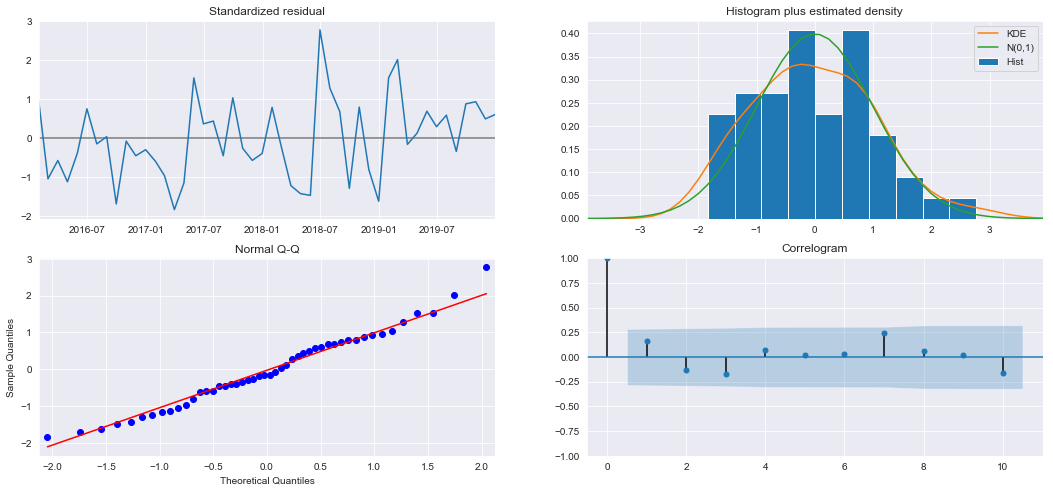

In [51]:
res.plot_diagnostics(figsize=(18, 8))
plt.show()

In [59]:
df_temp = pd.DataFrame(precipitation_labs.diff(12))

df1 = pd.DataFrame(offsets_labs.diff(12))
df2 = pd.DataFrame(offsets_gaps.diff(12))
df3 = pd.DataFrame(offsets_spots.diff(12))


df1.rename(columns={"offset50_smooth_mean": "labs"},inplace=True)
df2.rename(columns={"offset50_smooth_mean": "gaps"},inplace=True)
df3.rename(columns={"offset50_smooth_mean": "spots"},inplace=True)



endog = df1.join(df2, how='outer')
endog = endog.join(df3, how='outer')


endog['spots'] = (endog['spots'] - endog['spots'].mean()) / endog['spots'].std()
endog['gaps'] = (endog['gaps'] - endog['gaps'].mean()) / endog['gaps'].std()
endog['labs'] = (endog['labs'] - endog['labs'].mean()) / endog['labs'].std()


In [60]:
endog = endog.join(df_temp, how='outer')
endog.dropna(inplace = True)

endog['total_precipitation'] = (endog['total_precipitation'] - endog['total_precipitation'].mean()) / endog['total_precipitation'].std()


In [61]:

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
print(res.summary(separate_params=False))


                                          Statespace Model Results                                          
Dep. Variable:     ['labs', 'gaps', 'spots', 'total_precipitation']   No. Observations:                   36
Model:                            DynamicFactor(factors=1, order=1)   Log Likelihood                -134.052
                                                     + AR(2) errors   AIC                            302.104
Date:                                              Thu, 02 Apr 2020   BIC                            329.024
Time:                                                      17:47:24   HQIC                           311.500
Sample:                                                  01-31-2017                                         
                                                       - 12-31-2019                                         
Covariance Type:                                                opg                                         
                   

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


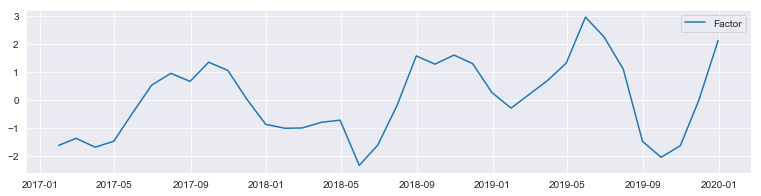

In [55]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.smoothed[0], label='Factor')
ax.legend()

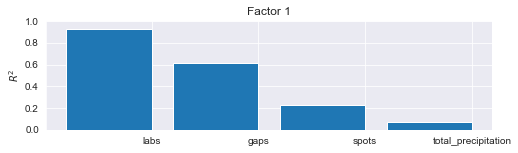

In [56]:
res.plot_coefficients_of_determination(figsize=(8,2));


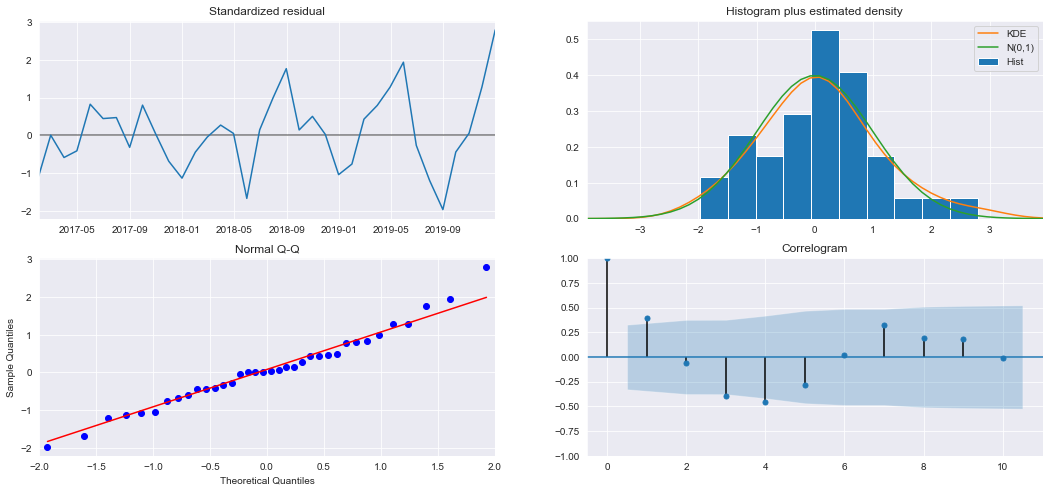

In [57]:
res.plot_diagnostics(figsize=(18, 8))
plt.show()